In [142]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import numpy.random as rnd
import random
import math
import copy

## 0. Parameters settings

In [143]:
num_pop = 100
dimension = 2
size = 9 #(-100<= X <=100 by binary)

crossover_prob = 0.7 # 0.7, 0.8, 0.9
mutation_prob = 0.05 # 0.01, 0.03, 0.05

function_selected = "Rastrigin" #Sphere #Rastrigin 

## 1. Functions

### 1.1. About chromosomes

In [144]:
"""
Generate random solution
"""
def generate_random_solution(size):
    solution = []
    chromosome = []
    sign = []
    
    # Chromosome
    current_size = 0
    while current_size < size:
        chromosome.append(random.randint(0,1))
        current_size = current_size + 1
    
    # Sign + -
    sign_candidate = [-1, 1]
    sign.append(random.choice(sign_candidate))

    # Merge solution
    solution.append(chromosome)
    solution.append(sign)
    # print(solution)

    return solution

"""
Chromosome genotype solution value function
"""

def chromosome_bin_to_decimal(chromosome): 
    #
    power = 6
    sum = 0
    # print(f'power: {power}')
    #
    for idx in range(0,len(chromosome[0])):
        # print((chromosome[0][idx]) * (2**power))
        sum = sum + (chromosome[0][idx]) * (2**power)
        power = power - 1
    
    
    return sum * chromosome[1][0]


### 1.2. Objective functions

In [145]:
"""
Sphere function(objective)
input: decimal
"""
def Sphere_function(x):
    return x**2

def Rastrigin_function(x):
    return (x**2 - 10 * math.cos(2*(math.pi)*x) + 10)


In [146]:
"""
Calculate objective function and judge the best solution
"""

def calculate_objective_function(solution_set):

    value_set = []
    for sol_idx in range(0, len(solution_set)):
        
        sum = 0
        if function_selected == 'Sphere':    
            for dim in range(0,dimension):
                sum = sum + Sphere_function(chromosome_bin_to_decimal(solution_set[sol_idx][dim]))
            value_set.append(sum)
            
        elif function_selected == 'Rastrigin':    
            for dim in range(0,dimension):
                sum = sum + Rastrigin_function(chromosome_bin_to_decimal(solution_set[sol_idx][dim]))
            value_set.append(sum)
        else:
            print("PLEASE SET YOUR FUNCTION")

    # print(value_set)
    
    return value_set

### 1.3. About selection

In [147]:
"""
Calculate objective function and compose selection probability (1st: 50%, 2nd: 25%, 3rd: 12.5% ...)
"""

def calculate_obj_and_compose_selection_probability(solution_set):

    value_set = calculate_objective_function(solution_set)
    
    # Ascending
    temp_df = pd.DataFrame({"index":(range(0,num_pop)), "obj.val": value_set})
    temp_df = temp_df.sort_values('obj.val', ascending=True)
    increasing_index = temp_df['index'].values.tolist()
       
    #
    selection_prob = [-999 for i in range(0,num_pop)]
    sum1_idx = 0
    for count in range(0,(num_pop-1)):
        #
        # print(f'{count}: {increasing_index}')
        where_point = increasing_index.index(count)
        selection_prob[where_point] = 0.5*(0.5)**(count)
        sum1_idx = sum1_idx + 0.5*(0.5)**(count)
    
    where_point = increasing_index.index(num_pop-1)
    selection_prob[where_point] = 1 - sum1_idx
    
    # print(f'selection_prob: {selection_prob}')
            
    return selection_prob



In [148]:
"""
Calculate objective function and compose selection probability based on reciprocal of fitness values
"""
def calculate_obj_and_compose_selection_probability_fitnessvalue(solution_set):
    
    value_set = calculate_objective_function(solution_set)
    # print(value_set)
    
    # Reciprocal
    value_recip_set = []
    for v in value_set:
        if v == 0:
            value_recip_set.append(0)
        else:
            value_recip_set.append(1/v)
    
    denom = np.sum(value_recip_set)
    selection_prob = []
    for i in value_recip_set:
        selection_prob.append(i/denom)
    
            
    return selection_prob

### 1.4. Crossver and Mutation

In [149]:
"""
One-point crossover
: between same dimension

"""
def execute_crossover_standard(solution_1, solution_2):
    
    solution_1_tmp = copy.deepcopy(solution_1)
    solution_2_tmp = copy.deepcopy(solution_2)
    # print(f'solution tmp: {solution_1_tmp}, {solution_2_tmp}')
    # Crossover
    dim = 0
    while dim < dimension:
        
        # Save current solutions
        current_sol1 = solution_1_tmp[dim][0]
        current_sol2 = solution_2_tmp[dim][0]
        # print(f'{current_sol1}\n{current_sol2}')
        
        # Copy the new solution from the current solutions
        new_sol1 = copy.deepcopy(current_sol1)
        new_sol2 = copy.deepcopy(current_sol2)
        
        # Find location for one-point crossover
        point_loc = random.randint(1,(len(current_sol1)-2))
        
        # print(f'len: {(len(current_sol1)-1)}')
        
        # print(f'point_loc: {point_loc}')
        
        for loc_idx in range(0, point_loc):
            new_sol1[loc_idx] = current_sol2[loc_idx]
            new_sol2[loc_idx] = current_sol1[loc_idx]
        
        solution_1_tmp[dim][0] = new_sol1
        solution_2_tmp[dim][0] = new_sol2
        
        # Update
        dim = dim + 1

    # print(f'{solution_1_tmp}\n{solution_2_tmp}')
    return solution_1_tmp, solution_2_tmp

"""
Modified crossover: crop & merge
"""
def execute_crossover_modified(solution_1, solution_2):
        
    solution_1_tmp = copy.deepcopy(solution_1)
    solution_2_tmp = copy.deepcopy(solution_2)
    print(f'solution tmp: {solution_1_tmp}, {solution_2_tmp}')
    # Crossover
    dim = 0
    while dim < dimension:
        
        # Save current solutions
        current_sol1 = solution_1_tmp[dim][0]
        current_sol2 = solution_2_tmp[dim][0]
        print(f'{current_sol1}\n{current_sol2}')
        
        # Copy the new solution from the current solutions
        new_sol1 = copy.deepcopy(current_sol1)
        new_sol2 = copy.deepcopy(current_sol2)
                
        # CROP: Find locations for crop in consecutive numbers (0~5) 
        crop_loc = random.randint(0,(len(current_sol1)-2))
        print(f'crop_loc: {crop_loc}')
        
        # MERGE: Find two locations for merge (7C2)
        merge_loc = list(range(len(current_sol1)))
        merge_list = random.sample(merge_loc, 2)
        print(f'merge_list: {merge_list}')
        
        #
        new_sol1[crop_loc] = current_sol2[merge_list[0]]
        new_sol1[crop_loc+1] = current_sol2[merge_list[1]]
        
        new_sol2[merge_list[0]] = current_sol1[crop_loc]
        new_sol2[merge_list[1]] = current_sol1[crop_loc+1]   
                
        solution_1_tmp[dim][0] = new_sol1
        solution_2_tmp[dim][0] = new_sol2
                
        # Update
        dim = dim + 1

    # print(f'{solution_1_tmp}\n{solution_2_tmp}')
    return solution_1_tmp, solution_2_tmp


In [150]:
"""
Standard mutation
: select only one
"""
def execute_mutation_standard(new_solution_1, new_solution_2):

    remember_signal = -99
    # Select
    if random.random() <= 0.5:
        mutation_target_chromosome = copy.deepcopy(new_solution_1)
        remember_signal = 1
    else:
        mutation_target_chromosome = copy.deepcopy(new_solution_2)
        remember_signal = 2
        
    # print("!: ",remember_signal)

    # Choose the location randomly along all dimension 
    dim = 0
    while dim < dimension:
        temp_chromosome = mutation_target_chromosome[dim][0]
        # print(temp_chromosome)
        
        point_loc = random.randint(0,(len(temp_chromosome)-1))
        
        # print(f'{point_loc}: {temp_chromosome[point_loc]}')
        
        if temp_chromosome[point_loc] == 0:
            temp_chromosome[point_loc] = 1
        else:
            temp_chromosome[point_loc] = 0
            
        # print(temp_chromosome)
        # print("\n")
        dim = dim + 1

    if remember_signal == 1:
        new_solution_1 = copy.deepcopy(mutation_target_chromosome)
    elif remember_signal == 2:
        new_solution_2 = copy.deepcopy(mutation_target_chromosome)
    else:
        print("error")
        
    return new_solution_1, new_solution_2

"""
Modified mutation
: select 1~3
"""
def execute_mutation_modified(new_solution_1, new_solution_2):
    pass

## 2. Generate initial population
[[0, 0, 1, 0, 0, 0, 0], [sign]]

In [151]:
"""
Example of chromosome
"""
chromosome = generate_random_solution(size)
val = chromosome_bin_to_decimal(chromosome)

print(chromosome)
print(val)

[[1, 0, 1, 0, 1, 0, 0, 0, 0], [1]]
84.0


In [152]:
"""
Generate intial population
"""
solution_set = []

successful_pop = 1
while successful_pop <= num_pop:
    
    # Generate    
    temp_solution_set = []
    success_dim = 0
    while success_dim < dimension:
        temp_chromosome = generate_random_solution(size)
        val = chromosome_bin_to_decimal(temp_chromosome)
    
        # for the warm initial solution: -100 ~ +100
        if (val >= -100) &  (val <= 100):
            temp_solution_set.append(temp_chromosome)
            success_dim = success_dim + 1
        else:
            pass
            # print(f'Infeasible!...')
    # Append
    solution_set.append(temp_solution_set)
    # print(f'Generated num of population: {successful_pop}')
    
    # Update
    successful_pop = successful_pop + 1
    
# OUTPUT: solution_set

In [153]:
for i in range(0, len(solution_set)):
    
    print(solution_set[i])

[[[0, 1, 0, 1, 1, 1, 1, 1, 0], [-1]], [[0, 1, 0, 0, 1, 1, 0, 1, 1], [1]]]
[[[0, 1, 1, 0, 1, 0, 1, 0, 0], [-1]], [[0, 0, 0, 1, 1, 1, 1, 0, 1], [1]]]
[[[0, 1, 1, 0, 1, 1, 1, 0, 1], [-1]], [[0, 1, 1, 1, 1, 1, 0, 1, 0], [1]]]
[[[1, 0, 0, 1, 0, 1, 1, 1, 1], [-1]], [[1, 0, 0, 0, 0, 0, 1, 0, 0], [1]]]
[[[0, 0, 1, 0, 0, 1, 0, 1, 1], [1]], [[0, 0, 1, 0, 1, 0, 1, 0, 0], [1]]]
[[[0, 1, 1, 0, 0, 0, 1, 1, 1], [-1]], [[0, 1, 1, 0, 1, 0, 1, 0, 0], [-1]]]
[[[0, 1, 0, 0, 0, 0, 0, 1, 1], [1]], [[0, 0, 0, 1, 0, 1, 0, 1, 1], [-1]]]
[[[0, 1, 1, 1, 1, 1, 1, 1, 1], [-1]], [[0, 1, 1, 1, 0, 0, 0, 0, 0], [-1]]]
[[[0, 1, 1, 0, 0, 0, 0, 1, 0], [1]], [[0, 0, 0, 0, 0, 1, 1, 1, 1], [-1]]]
[[[0, 0, 0, 0, 1, 1, 0, 0, 0], [1]], [[1, 0, 0, 1, 1, 0, 0, 1, 0], [1]]]
[[[0, 1, 1, 1, 0, 1, 0, 0, 0], [-1]], [[0, 0, 1, 1, 0, 0, 0, 0, 1], [-1]]]
[[[1, 0, 0, 1, 1, 1, 0, 0, 0], [1]], [[0, 0, 1, 0, 0, 0, 1, 0, 0], [-1]]]
[[[0, 0, 0, 0, 0, 1, 1, 1, 0], [-1]], [[0, 0, 0, 1, 1, 1, 1, 1, 0], [-1]]]
[[[0, 0, 0, 1, 0, 0, 0, 1, 1], [-1]]

## 3. Roulette-wheel selection

In [154]:
"""
Set the roulette-wheel and select two individual solutions
"""
obj_list = calculate_objective_function(solution_set)
print(obj_list)

# selection probability based on fitness values
selection_prob = calculate_obj_and_compose_selection_probability(solution_set)
print(selection_prob)


# select only two chromosomes within 1~Npop
num_list = list(range(0,(num_pop)))
print(num_list)


selected_pop = np.random.choice(num_list, 2, p=selection_prob, replace=False)
print(selected_pop)


[3787.8125, 3051.5625, 6988.8125, 9973.0625, 802.5625, 5294.0625, 1208.125, 7210.0625, 2396.3125, 5908.25, 3962.0625, 6373.0, 292.5, 7482.5625, 4974.0625, 785.6250000000001, 9077.0, 9104.0625, 2763.3125, 5835.3125, 2462.3125, 6376.125, 3115.5625000000005, 5477.125, 3050.0, 9949.0625, 6459.3125, 8192.25, 1682.0, 10057.0, 6082.5, 140.06249999999991, 4277.124999999999, 9286.0625, 5846.3125, 10047.8125, 10991.5625, 396.56249999999994, 1263.1249999999998, 2100.3125, 5386.5, 2948.125, 9516.625, 5142.5625, 6970.8125, 6704.625, 9237.5625, 10242.625, 12717.25, 11490.625, 2043.625, 9321.8125, 8214.5, 9457.8125, 1298.25, 2465.0, 1076.0, 3401.625, 9636.5, 2387.0625, 1401.25, 6225.625, 258.3125, 4866.25, 14202.5625, 5073.25, 6097.125, 3576.5625, 3503.125, 5379.25, 11979.3125, 3769.8124999999995, 12688.5, 500.25, 8851.25, 6828.25, 6055.125, 2858.0625, 6358.8125, 15678.3125, 1822.125, 9093.125, 8450.0, 6750.625, 683.5625, 7416.5625, 252.31249999999991, 9977.25, 682.5, 4954.0625, 13296.5625, 1979.6250

## 4. Crossover

In [155]:
"""
Execute crossover with crossover probability: select only two
"""
# Selected two solutions
solution_1 = solution_set[selected_pop[0]]
solution_2 = solution_set[selected_pop[1]]
print(f'current\n{solution_1}\n{solution_2}')

if random.random() <= crossover_prob:
    new_solution_1, new_solution_2 = execute_crossover_standard(solution_1, solution_2)
    print(f'new\n{new_solution_1}\n{new_solution_2}')


current
[[[0, 0, 0, 1, 0, 0, 1, 0, 1], [1]], [[0, 1, 1, 1, 0, 1, 1, 0, 0], [1]]]
[[[0, 0, 0, 0, 1, 0, 1, 0, 0], [1]], [[0, 0, 0, 1, 0, 1, 0, 0, 1], [1]]]


## 5. Mutation

In [156]:
"""
Execute muatation with crossover probability: select only one solution between two solutions
"""

print(f'current\n{new_solution_1}\n{new_solution_2}')
if random.random() <= mutation_prob: # mutation_prob
    new_solution_1, new_solution_2 = execute_mutation_standard(new_solution_1, new_solution_2)
    print(f'new\n{new_solution_1}\n{new_solution_2}')

current
[[[0, 0, 0, 0, 0, 0, 0, 0, 0], [-1]], [[0, 0, 0, 0, 0, 0, 0, 0, 0], [1]]]
[[[0, 0, 0, 0, 0, 0, 0, 0, 0], [-1]], [[0, 0, 0, 0, 0, 0, 0, 0, 0], [1]]]


## 6. Alternate

In [157]:
"""
Alternative I
"""
def alternative_1(solution_set, new_solution_1, new_solution_2):
   
    solution_set[selected_pop[0]] = new_solution_1
    solution_set[selected_pop[1]] = new_solution_2
    
    return solution_set

In [158]:
"""
Alternative II
"""
def alternative_2(solution_set, new_solution_1, new_solution_2):
    alt2_solution_set = copy.deepcopy(solution_set)
    alt2_obj_set = copy.deepcopy(calculate_objective_function(solution_set))

    
    if function_selected == 'Sphere':
        # new_solution_1
        sum_new1 = 0
        for dim in range(0,dimension):
            sum_new1 = sum_new1 + Sphere_function(chromosome_bin_to_decimal(new_solution_1[dim]))
        alt2_solution_set.append(new_solution_1)
        alt2_obj_set.append(sum_new1)


        # new_solution_2
        sum_new2 = 0
        for dim in range(0,dimension):
            sum_new2 = sum_new2 + Sphere_function(chromosome_bin_to_decimal(new_solution_2[dim]))
        alt2_solution_set.append(new_solution_2)
        alt2_obj_set.append(sum_new2)
        
    elif function_selected == 'Rastrigin':
            # new_solution_1
        sum_new1 = 0
        for dim in range(0,dimension):
            sum_new1 = sum_new1 + Rastrigin_function(chromosome_bin_to_decimal(new_solution_1[dim]))
        alt2_solution_set.append(new_solution_1)
        alt2_obj_set.append(sum_new1)


        # new_solution_2
        sum_new2 = 0
        for dim in range(0,dimension):
            sum_new2 = sum_new2 + Rastrigin_function(chromosome_bin_to_decimal(new_solution_2[dim]))
        alt2_solution_set.append(new_solution_2)
        alt2_obj_set.append(sum_new2)
        
    else:
        print("PLEASE SET YOUR FUNCTION!")

    # Remove twice
    ##
    temp_df = pd.DataFrame({"index":(range(0,num_pop+2)), "obj.val": alt2_obj_set})
    # print(temp_df)
    temp_df = temp_df.sort_values('obj.val', ascending=True)
    # print(temp_df)
    increasing_index = temp_df['index'].values.tolist()
    
    # print(increasing_index)
    # print(alt2_obj_set)
     
    alt2_solution_set.pop(increasing_index[-1])
    alt2_obj_set.pop(increasing_index[-1])

    ##
    temp_df = pd.DataFrame({"index":(range(0,num_pop+1)), "obj.val": alt2_obj_set})
    # print(temp_df)
    temp_df = temp_df.sort_values('obj.val', ascending=True)
    # print(temp_df)
    increasing_index = temp_df['index'].values.tolist()
    
    # print(increasing_index)
    # print(alt2_obj_set)
     
    alt2_solution_set.pop(increasing_index[-1])
    alt2_obj_set.pop(increasing_index[-1])

    # print(alt2_obj_set)
    

    # Replace solution_set with alt2_solution_set
    return alt2_solution_set

## 7. Indicator plot(operators analysis)

In [159]:
"""
Take coordinates under dimension
"""
def take_coordinates(solution_set):
    
    x_set = []
    for sol_idx in range(0, len(solution_set)):
        
        x_tmp = []
        for dim in range(0,dimension):
            x_tmp.append(chromosome_bin_to_decimal(solution_set[sol_idx][dim]))
        x_set.append(x_tmp)

    return x_set
        
    # return value_set

In [160]:
"""
Calculate distances between D points(dimensions), Euclidean
"""
# def euclidean_distance(solution_set, iteration):
plot_for_indicators = take_coordinates(solution_set) 

print(plot_for_indicators)

max_dist = -999

# p ~ q
for i in range(0,num_pop):
    
    p_set = plot_for_indicators[i]
    for j in range(0, num_pop):
        q_set = plot_for_indicators[j]
        
        sum = 0
        for dim in range(0,dimension):
            sum = (p_set[dim]-q_set[dim])**2
        
        distance = math.sqrt(sum)
        if max_dist <= distance:
            max_dist = distance

print(max_dist)
# return max_dist


[[-47.5, 38.75], [-53.0, 15.25], [-55.25, 62.5], [-75.75, 65.0], [18.75, 21.0], [-49.75, -53.0], [32.75, -10.75], [-63.75, -56.0], [48.5, -3.75], [6.0, 76.5], [-58.0, -24.25], [78.0, -17.0], [-3.5, -15.5], [-8.75, 86.0], [-14.25, -69.0], [22.75, -15.75], [41.0, -86.0], [-34.25, 89.0], [25.75, 45.5], [75.5, 10.25], [-40.25, 28.5], [-36.75, 70.75], [-48.75, -27.0], [21.25, -70.75], [47.0, 29.0], [-39.0, 91.75], [-53.75, -59.5], [54.0, -72.5], [41.0, 1.0], [96.0, -29.0], [71.5, 30.5], [5.0, 10.25], [36.25, 54.25], [-79.75, -54.0], [1.5, 76.25], [88.5, -46.75], [-65.25, 82.0], [-4.0, -19.25], [14.25, 32.25], [-24.25, -38.5], [42.5, -59.5], [46.75, 27.25], [-77.75, -58.75], [-58.75, 41.0], [-20.5, 80.75], [81.75, -1.25], [-61.25, 74.0], [40.25, 92.75], [87.5, -71.0], [55.25, -91.75], [16.75, -41.75], [-90.75, 32.5], [88.5, 18.5], [-66.5, 70.75], [26.5, 24.0], [-16.0, -47.0], [-26.0, -20.0], [-14.75, -56.25], [97.5, 9.5], [-31.75, 37.0], [35.0, -12.5], [76.75, -17.75], [4.25, -14.5], [69.5, 

In [161]:
ppp = plot_for_indicators[0]
qqq = plot_for_indicators[1]

print(ppp, qqq)

print(ppp[1] - qqq[1])
print(dimension)

[-47.5, 38.75] [-53.0, 15.25]
23.5
2


In [162]:
"""
Basis plot
"""
def basis_plot(solution_set, iteration):
    plot_for_indicators = take_coordinates(solution_set)    
    x, y = zip(*plot_for_indicators)
    
    plt.scatter(x,y, s=12, color='black')
    plt.scatter(0,0, s=12, color='red')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.xlim([-120, 120])      # X축의 범위: [xmin, xmax]
    plt.ylim([-120, 120]) 
    plt.title(f'Iteration: {iteration}, Crossover_prob: {crossover_prob}, Mutation_prob: {mutation_prob}')
    plt.show()

    print(f'plot_for_indicators: {plot_for_indicators}')
    print(f'minimum value: {min(calculate_objective_function(solution_set))}')
    
"""
Exploration
: Area of maximal radius circle
"""







"""
Exploitation
: (current area) / (initial area)
"""


print("!")


!


In [163]:
plot_for_indicators = take_coordinates(solution_set)
print(plot_for_indicators)

[[-47.5, 38.75], [-53.0, 15.25], [-55.25, 62.5], [-75.75, 65.0], [18.75, 21.0], [-49.75, -53.0], [32.75, -10.75], [-63.75, -56.0], [48.5, -3.75], [6.0, 76.5], [-58.0, -24.25], [78.0, -17.0], [-3.5, -15.5], [-8.75, 86.0], [-14.25, -69.0], [22.75, -15.75], [41.0, -86.0], [-34.25, 89.0], [25.75, 45.5], [75.5, 10.25], [-40.25, 28.5], [-36.75, 70.75], [-48.75, -27.0], [21.25, -70.75], [47.0, 29.0], [-39.0, 91.75], [-53.75, -59.5], [54.0, -72.5], [41.0, 1.0], [96.0, -29.0], [71.5, 30.5], [5.0, 10.25], [36.25, 54.25], [-79.75, -54.0], [1.5, 76.25], [88.5, -46.75], [-65.25, 82.0], [-4.0, -19.25], [14.25, 32.25], [-24.25, -38.5], [42.5, -59.5], [46.75, 27.25], [-77.75, -58.75], [-58.75, 41.0], [-20.5, 80.75], [81.75, -1.25], [-61.25, 74.0], [40.25, 92.75], [87.5, -71.0], [55.25, -91.75], [16.75, -41.75], [-90.75, 32.5], [88.5, 18.5], [-66.5, 70.75], [26.5, 24.0], [-16.0, -47.0], [-26.0, -20.0], [-14.75, -56.25], [97.5, 9.5], [-31.75, 37.0], [35.0, -12.5], [76.75, -17.75], [4.25, -14.5], [69.5, 

## @@ Iteration test @@

In [164]:
MAX_ITR = 1000

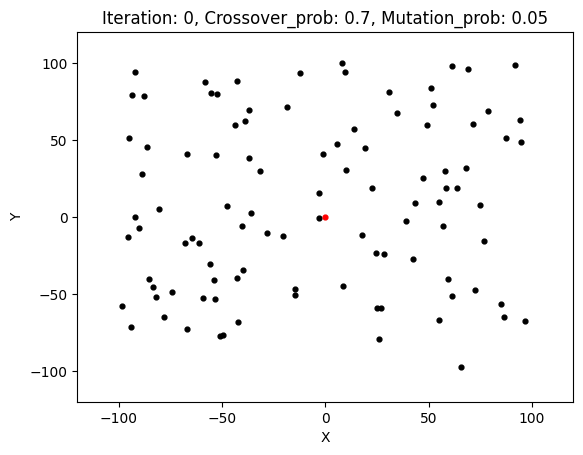

plot_for_indicators: [[-78.25, -64.75], [51.0, 83.75], [34.75, 67.25], [-12.0, 93.5], [76.75, -15.75], [25.25, -59.25], [-98.5, -58.0], [-38.75, 62.0], [-14.75, -46.75], [-31.75, 29.75], [-42.0, -68.5], [75.0, 8.0], [61.25, 97.75], [55.0, 9.5], [-52.5, 79.5], [-37.0, 69.25], [-47.5, 7.0], [63.5, 18.5], [-92.0, -0.25], [61.5, -51.5], [31.0, 81.0], [-14.5, -50.75], [27.0, -59.25], [-59.25, -52.75], [47.5, 25.5], [-86.5, 45.5], [59.5, -40.25], [-20.25, -12.5], [-55.75, -30.25], [-67.0, 40.75], [-3.0, 15.25], [55.25, -66.75], [-55.5, 80.5], [52.0, 73.0], [92.0, 98.75], [-51.0, -77.0], [-37.0, 38.0], [-83.25, -45.25], [-74.0, -48.75], [69.25, 96.0], [28.5, -24.25], [26.0, -79.0], [68.25, 32.0], [43.5, 9.25], [-35.75, 2.75], [-58.0, 87.5], [-61.0, -16.75], [-67.75, -17.25], [13.75, 57.0], [-67.0, -72.75], [86.5, -65.25], [-1.25, 40.75], [10.0, 30.5], [24.5, -23.75], [8.0, 100.0], [17.75, -12.0], [-42.5, -39.5], [39.25, -2.75], [-90.0, -7.5], [-82.0, -51.75], [-88.5, 27.75], [-42.5, 88.5], [-

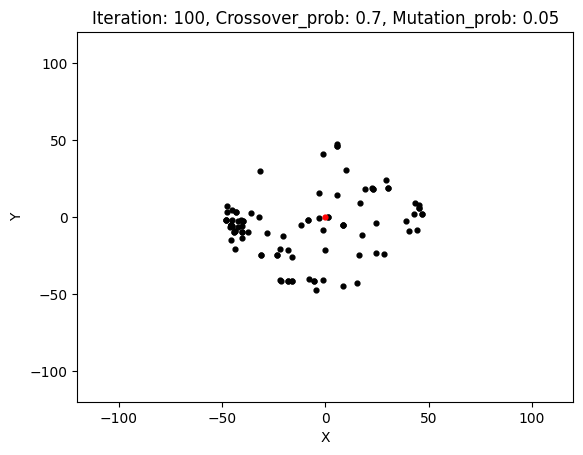

plot_for_indicators: [[-31.75, 29.75], [-47.5, 7.0], [-20.25, -12.5], [-3.0, 15.25], [28.5, -24.25], [43.5, 9.25], [-35.75, 2.75], [-1.25, 40.75], [10.0, 30.5], [24.5, -23.75], [17.75, -12.0], [39.25, -2.75], [-3.25, -1.0], [22.5, 18.75], [-28.0, -10.5], [5.75, 47.5], [-40.25, -5.75], [8.5, -45.0], [-45.75, -5.0], [-45.75, -5.0], [-45.75, -5.0], [-45.75, -5.0], [-45.75, -5.0], [5.5, 46.0], [5.5, 46.0], [-45.25, -5.75], [-43.0, 3.25], [-43.0, 3.25], [-48.25, -1.75], [23.0, 18.0], [23.0, 18.0], [-40.0, -2.75], [-40.0, -2.75], [-1.25, -40.75], [24.5, -3.75], [8.5, -5.0], [8.5, -5.0], [8.5, -5.0], [-45.0, -5.75], [-40.75, -2.0], [-44.25, -9.75], [-18.25, -41.75], [-18.25, -41.75], [-44.25, -9.75], [-16.25, -41.75], [-16.25, -25.75], [5.5, 14.0], [-5.25, -41.75], [-5.25, -41.75], [-48.25, -1.75], [-40.25, -13.75], [45.5, 5.5], [-43.75, -9.0], [-43.75, -9.0], [-8.0, -40.25], [-21.75, -21.0], [47.0, 2.0], [-45.75, -5.0], [-45.25, 4.75], [40.5, -9.0], [-11.75, -5.0], [-45.75, -15.0], [-18.25, 

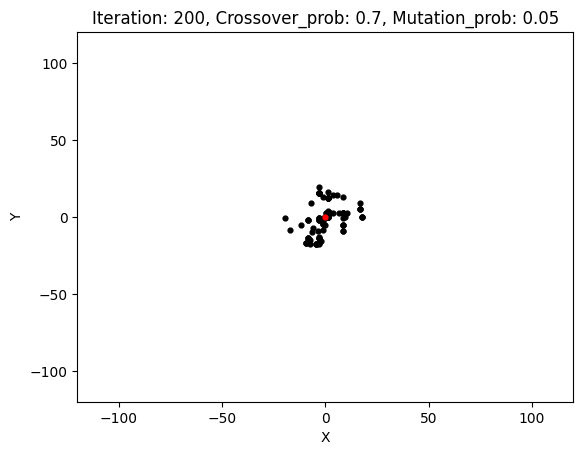

plot_for_indicators: [[-3.0, 15.25], [-3.25, -1.0], [8.5, -5.0], [8.5, -5.0], [8.5, -5.0], [5.5, 14.0], [-11.75, -5.0], [17.0, 9.0], [-1.25, -8.75], [-8.25, -1.75], [-8.25, -1.75], [1.5, 0.0], [1.5, 0.0], [-5.75, -7.0], [-17.25, -8.75], [1.5, 16.0], [8.5, 2.75], [8.5, 2.75], [8.5, 2.75], [8.5, 2.75], [8.5, 2.75], [1.5, 12.0], [-3.75, -9.0], [-1.25, -2.75], [8.5, -9.0], [17.0, 5.0], [-1.25, -4.75], [8.5, -9.0], [-4.25, -17.75], [10.5, 2.75], [-7.25, -15.0], [8.5, -1.0], [-3.25, -17.0], [-3.25, -17.75], [-8.25, -1.75], [9.5, 0.0], [0.5, 2.75], [1.5, 12.0], [1.5, 12.0], [-1.25, -4.75], [-1.25, -4.75], [-0.25, -0.75], [-3.0, 15.25], [-3.0, 15.25], [-4.0, -17.75], [6.5, 2.75], [3.5, 2.75], [-3.0, 15.25], [-19.25, -1.0], [-7.25, -17.75], [-6.25, -9.75], [0.5, 2.75], [-3.25, -1.75], [-3.0, 15.25], [-3.0, 15.25], [-2.25, -15.75], [-7.0, 9.25], [-4.25, -17.75], [-3.25, -1.75], [-4.25, -17.75], [-3.25, -1.75], [1.5, 0.0], [-3.25, -13.75], [1.5, 0.0], [-3.25, -13.75], [1.5, 0.0], [-3.25, -13.75],

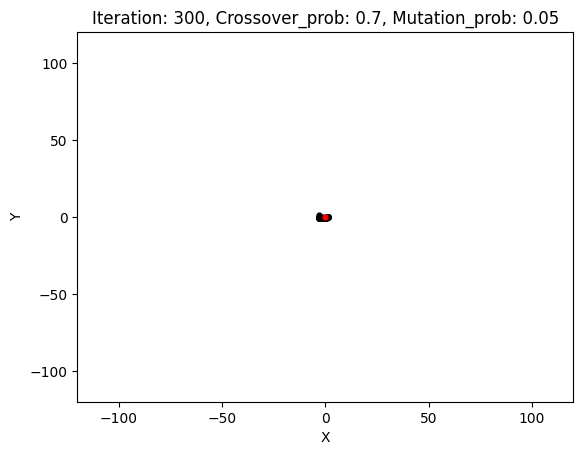

plot_for_indicators: [[-3.25, -1.0], [1.5, 0.0], [1.5, 0.0], [-0.25, -0.75], [1.5, 0.0], [1.5, 0.0], [1.5, 0.0], [1.5, 0.0], [1.5, 0.0], [-3.25, -1.0], [-3.25, -1.0], [-1.25, -0.75], [-1.25, -0.75], [-3.25, -1.0], [-3.25, -1.0], [-3.25, -1.0], [-3.0, 1.25], [1.5, 0.0], [-1.25, -0.75], [-1.25, -0.75], [1.5, 0.0], [-3.25, -1.0], [1.5, 0.0], [-1.25, -1.0], [-1.25, -1.0], [-1.25, -1.0], [0.5, -1.0], [0.5, -1.0], [-3.25, -0.0], [1.5, 0.0], [1.5, 0.0], [1.5, 0.0], [1.5, 0.0], [0.5, -1.0], [0.5, -1.0], [-1.25, -0.75], [-1.25, -0.75], [0.5, -1.0], [0.5, -1.0], [0.5, -1.0], [0.5, -1.0], [-1.25, -0.75], [-0.25, -1.0], [-3.25, -1.0], [-1.25, -1.0], [-3.25, -0.0], [-1.25, -0.75], [-1.25, -0.75], [-3.25, -1.0], [-1.25, -0.75], [1.5, 0.0], [-3.25, -0.0], [1.5, 0.0], [-3.25, -1.0], [0.5, -1.0], [-3.25, -1.0], [0.5, -1.0], [0.5, -1.0], [1.5, 0.0], [0.5, -1.0], [0.5, 0.0], [1.5, 0.0], [-3.25, -1.0], [-1.25, -0.75], [0.5, -1.0], [0.5, -1.0], [0.5, -1.0], [-3.25, -1.0], [-1.25, -0.0], [-1.25, -0.75], [-1

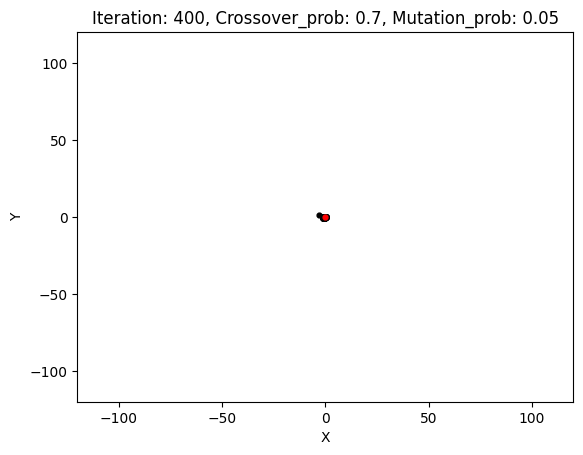

plot_for_indicators: [[-3.0, 1.25], [-1.25, -1.0], [-1.25, -1.0], [-1.25, -1.0], [-0.25, -1.0], [-1.25, -1.0], [0.5, 0.0], [-1.25, -0.0], [-1.25, -1.0], [-0.25, -1.0], [-1.25, -1.0], [-1.25, -1.0], [-1.25, -1.0], [-1.25, -0.0], [0.5, 0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-0.25, -1.0], [0.5, 0.0], [0.5, 0.0], [-1.25, -1.0], [-1.25, -0.0], [-0.25, -0.0], [0.5, 0.0], [0.5, 0.0], [0.5, 0.0], [-1.25, -0.0], [0.5, 0.0], [-1.25, -0.0], [0.5, -0.0], [-1.25, -1.0], [0.5, -0.0], [-1.25, -1.0], [-1.25, -0.0], [-1.25, -1.0], [-1.25, -0.0], [0.5, 0.0], [-1.25, -0.0], [-1.25, -1.0], [-1.25, -0.0], [-0.25, -1.0], [-1.25, -0.0], [-0.25, -0.0], [-0.25, -1.0], [-1.25, -1.0], [-0.25, -1.0], [-1.25, -0.0], [0.5, 0.0], [-0.25, -1.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [0.5, -0.0], [-1.25, -0.0], [0.5, -0.0], [0.5, 0.0], [0.5, 0.0], [-1.25, -0.0], [-0.25, -1.0], [-1.0, -1.0], [-0.25, -1.0], [-1.0, -1.0], [-1.25, -0.0], [0.5,

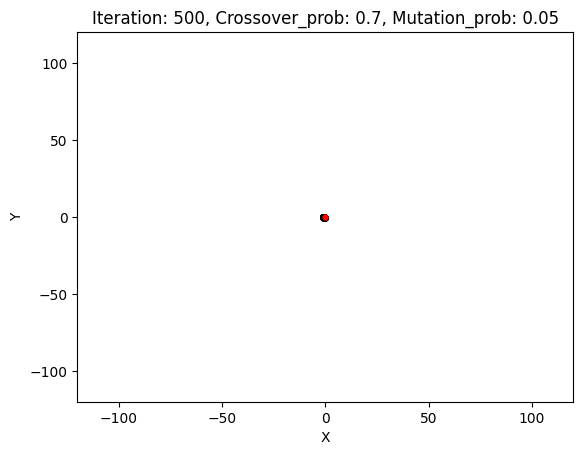

plot_for_indicators: [[-0.25, -1.0], [-1.25, -0.0], [-0.25, -1.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-0.25, -1.0], [-1.25, -0.0], [-0.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-0.25, -1.0], [-1.25, -0.0], [-0.25, -0.0], [-0.25, -1.0], [-0.25, -1.0], [-1.25, -0.0], [-0.25, -1.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-0.25, -1.0], [-1.0, -1.0], [-0.25, -1.0], [-1.0, -1.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-0.25, -1.0], [-1.25, -0.0], [-1.25, -0.0], [-0.25, -1.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.2

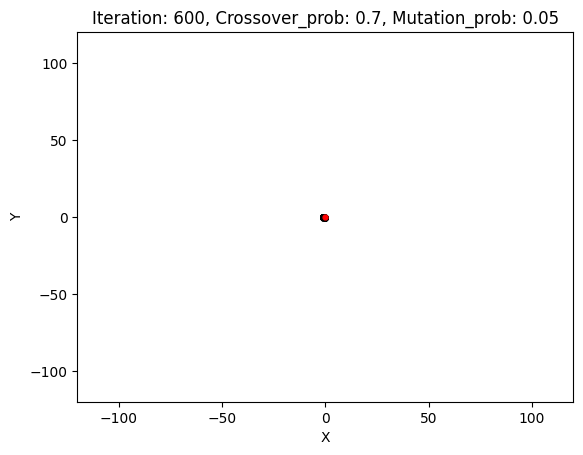

plot_for_indicators: [[-0.25, -1.0], [-1.25, -0.0], [-0.25, -1.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-0.25, -1.0], [-1.25, -0.0], [-0.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-0.25, -1.0], [-1.25, -0.0], [-0.25, -0.0], [-0.25, -1.0], [-0.25, -1.0], [-1.25, -0.0], [-0.25, -1.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-0.25, -1.0], [-1.0, -1.0], [-0.25, -1.0], [-1.0, -1.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-0.25, -1.0], [-1.25, -0.0], [-1.25, -0.0], [-0.25, -1.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.2

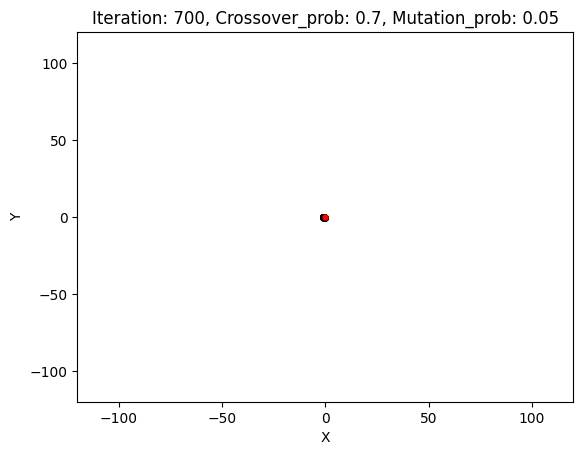

plot_for_indicators: [[-0.25, -1.0], [-1.25, -0.0], [-0.25, -1.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-0.25, -1.0], [-1.25, -0.0], [-0.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-0.25, -1.0], [-1.25, -0.0], [-0.25, -0.0], [-0.25, -1.0], [-0.25, -1.0], [-1.25, -0.0], [-0.25, -1.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-0.25, -1.0], [-1.0, -1.0], [-0.25, -1.0], [-1.0, -1.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-0.25, -1.0], [-1.25, -0.0], [-1.25, -0.0], [-0.25, -1.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.2

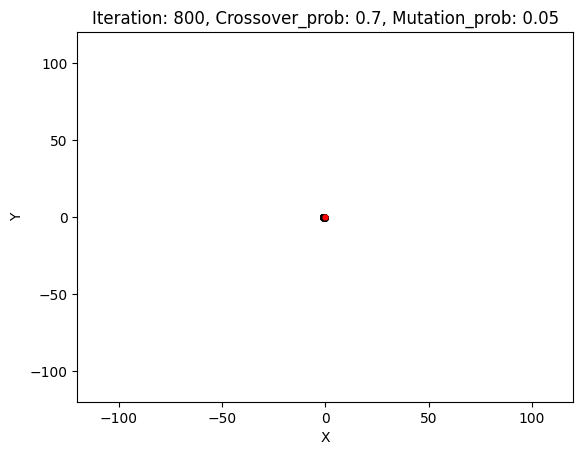

plot_for_indicators: [[-0.25, -1.0], [-1.25, -0.0], [-0.25, -1.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-0.25, -1.0], [-1.25, -0.0], [-0.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-0.25, -1.0], [-1.25, -0.0], [-0.25, -0.0], [-0.25, -1.0], [-0.25, -1.0], [-1.25, -0.0], [-0.25, -1.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-0.25, -1.0], [-1.0, -1.0], [-0.25, -1.0], [-1.0, -1.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-0.25, -1.0], [-1.25, -0.0], [-1.25, -0.0], [-0.25, -1.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.2

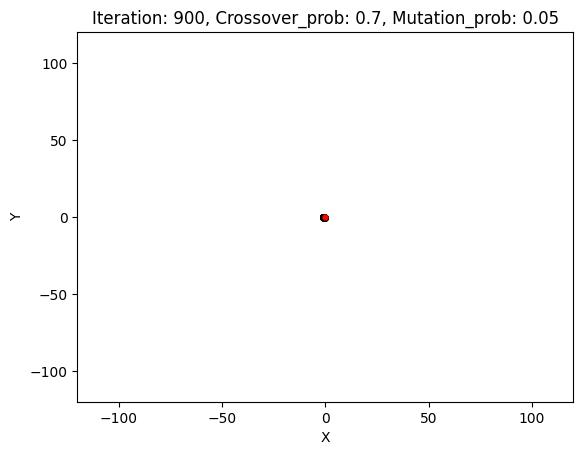

plot_for_indicators: [[-0.25, -1.0], [-1.25, -0.0], [-0.25, -1.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-0.25, -1.0], [-1.25, -0.0], [-0.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-0.25, -1.0], [-1.25, -0.0], [-0.25, -0.0], [-0.25, -1.0], [-0.25, -1.0], [-1.25, -0.0], [-0.25, -1.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-0.25, -1.0], [-1.0, -1.0], [-0.25, -1.0], [-1.0, -1.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-0.25, -1.0], [-1.25, -0.0], [-1.25, -0.0], [-0.25, -1.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.2

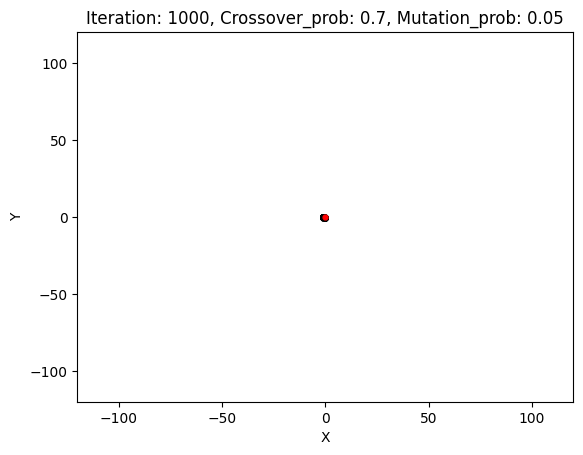

plot_for_indicators: [[-0.25, -1.0], [-1.25, -0.0], [-0.25, -1.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-0.25, -1.0], [-1.25, -0.0], [-0.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-0.25, -1.0], [-1.25, -0.0], [-0.25, -0.0], [-0.25, -1.0], [-0.25, -1.0], [-1.25, -0.0], [-0.25, -1.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-0.25, -1.0], [-1.0, -1.0], [-0.25, -1.0], [-1.0, -1.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-0.25, -1.0], [-1.25, -0.0], [-1.25, -0.0], [-0.25, -1.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.25, -0.0], [-1.2

In [165]:
"""
Generate intial population
"""

list_for_plot = []

#
solution_set = []
successful_pop = 1
while successful_pop <= num_pop:
    
    # Generate    
    temp_solution_set = []
    success_dim = 0
    while success_dim < dimension:
        temp_chromosome = generate_random_solution(size)
        val = chromosome_bin_to_decimal(temp_chromosome)
    
        # for the warm initial solution: -100 ~ +100
        if (val >= -100) &  (val <= 100):
            temp_solution_set.append(temp_chromosome)
            success_dim = success_dim + 1
        else:
            pass
            # print(f'Infeasible!...')
    # Append
    solution_set.append(temp_solution_set)
    # print(f'Generated num of population: {successful_pop}')
    
    # Update
    successful_pop = successful_pop + 1

iteration = 0
basis_plot(solution_set, iteration)



iteration = 1
while iteration <= MAX_ITR:

    """
    Set the roulette-wheel and select two individual solutions
    """

    # selection probability based on fitness values
    
    selection_prob = calculate_obj_and_compose_selection_probability(solution_set)
    # selection_prob = calculate_obj_and_compose_selection_probability_fitnessvalue(solution_set)

    # 1~Npop
    num_list = list(range(0,num_pop))
    selected_pop = np.random.choice(num_list, 2, p=selection_prob, replace=False)
    # print(selected_pop)

    """
    Execute crossover with crossover probability: select only two
    """
    # Selected two solutions
    solution_1 = solution_set[selected_pop[0]]
    solution_2 = solution_set[selected_pop[1]]
    # print(f'current\n{solution_1}\n{solution_2}')

    if random.random() <= crossover_prob:
        new_solution_1, new_solution_2 = execute_crossover_standard(solution_1, solution_2)
        # print(f'new\n{new_solution_1}\n{new_solution_2}')

    """
    Execute muatation with crossover probability: select only one solution between two solutions
    """

    # print(f'current\n{new_solution_1}\n{new_solution_2}')
    if random.random() <= mutation_prob: # mutation_prob
        new_solution_1, new_solution_2 = execute_mutation_standard(new_solution_1, new_solution_2)
    # print(f'current\n{new_solution_1}\n{new_solution_2}')


    """
    Alternative I or II
    """
    solution_set = alternative_2(solution_set, new_solution_1, new_solution_2)    
    
    
    """
    Evaluation
    """
    iterative_solution_set = calculate_objective_function(solution_set)
    
    # print(f'{iteration} | Best solution {solution_set[iterative_solution_set.index(min(iterative_solution_set))]}, value: {min(iterative_solution_set)}, index: {iterative_solution_set.index(min(iterative_solution_set))}')
    list_for_plot.append(min(iterative_solution_set))
    
    """
    Basis plot
    """
    if iteration%100 == 0:
        basis_plot(solution_set, iteration)
        
        
    
    # Update
    iteration = iteration + 1



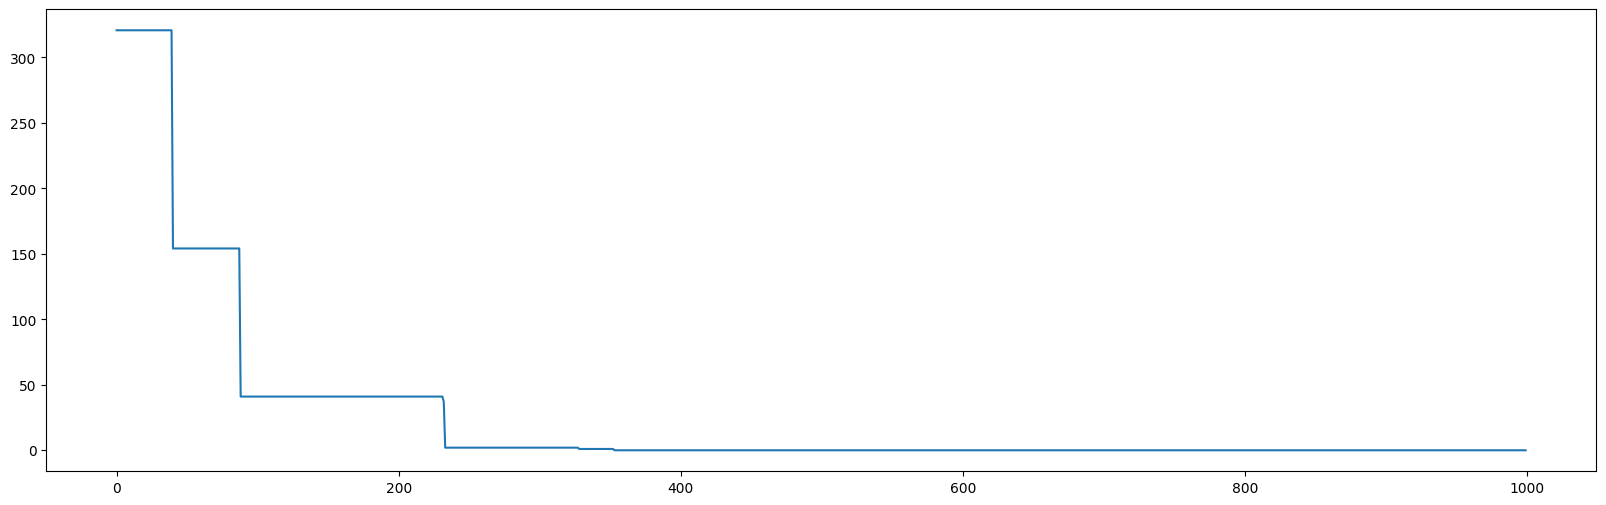

In [141]:
plt.figure(figsize=(20,6))
plt.plot(list_for_plot)
plt.show()

In [552]:
"""
Develop indicators(Exploration/Exploitation)
"""

'\nDevelop indicators(Exploration/Exploitation)\n'

## Dev note
- 전반적으로 오류나는거 체크(len 범위 착각)
- selection 할때 1, 2등에 거의 몰빵해야 함 예) 50*(1/2)**(r-100)
- Update하고 나서 feasibility 체크 따로 안 해도 될까?

In [722]:
for r in range(0, 100):
    print(50*(0.5)**(r))

50.0
25.0
12.5
6.25
3.125
1.5625
0.78125
0.390625
0.1953125
0.09765625
0.048828125
0.0244140625
0.01220703125
0.006103515625
0.0030517578125
0.00152587890625
0.000762939453125
0.0003814697265625
0.00019073486328125
9.5367431640625e-05
4.76837158203125e-05
2.384185791015625e-05
1.1920928955078125e-05
5.9604644775390625e-06
2.9802322387695312e-06
1.4901161193847656e-06
7.450580596923828e-07
3.725290298461914e-07
1.862645149230957e-07
9.313225746154785e-08
4.6566128730773926e-08
2.3283064365386963e-08
1.1641532182693481e-08
5.820766091346741e-09
2.9103830456733704e-09
1.4551915228366852e-09
7.275957614183426e-10
3.637978807091713e-10
1.8189894035458565e-10
9.094947017729282e-11
4.547473508864641e-11
2.2737367544323206e-11
1.1368683772161603e-11
5.6843418860808015e-12
2.8421709430404007e-12
1.4210854715202004e-12
7.105427357601002e-13
3.552713678800501e-13
1.7763568394002505e-13
8.881784197001252e-14
4.440892098500626e-14
2.220446049250313e-14
1.1102230246251565e-14
5.551115123125783e-15
2

In [673]:
print(len(selection_prob))

num_list = list(range(1,(num_pop+1)))
selected_pop = np.random.choice(num_list, 2, p=selection_prob, replace=False)



100


ValueError: probabilities contain NaN